![](../images/rivacon_frontmark_combined_header.png)

# Equity Volatility Surfaces

In [1]:
import matplotlib
matplotlib.use('nbagg')
import rivapy
from rivapy import marketdata as mkt_data
from rivapy import enums as enums
import pyvacon
# import pyvacon.analytics as analytics
import datetime as dt
# import pyvacon.tools.converter as converter
# import pyvacon.tools.enums as enums
import math
import numpy as np
# import pyvacon.marketdata.plot as mkt_plot #import module for plotting functionality
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
#the next lin is a jupyter internal command to show the matplotlib graphs within the notebook
#%matplotlib inline

## General Remarks
An equity volatility surface is an object providing for arbitrary expiries and strikes implied volatilities. The volatility surfaces provided by the analytics library are parametrized w.r.t. the so-called X-strikes, i.e. one has to put in a strike w.r.t. the X-variable which is the driving process of the spot $S$, i.e.
$$ S_t=(F_t-D_t)X_t+D_t$$
where $F_t$ is the risky forward and $D_t$ the cash dividends, see [Buehler](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1141877) for a more detailed discussion. 

To create a volatility surface one needs two components:
- A reference forward curve (typically the forward curve which was used to compute the implieds from quoted prices)
- A volatility parametrization



## Creating Forward Curve
We create a dummy forward curve as shown in the  [forward_curve](equity_forwardcurve.ipynb) notebook which will be used in all subsequent volatility surface constructions.

In [2]:
refdate = dt.datetime(2017,1,1)

#dividend table neede fo forward curve
object_id = "TEST_DIV" 
ex_dates = [dt.datetime(2018,3,29), dt.datetime(2019,3,29), dt.datetime(2020,3,29), dt.datetime(2021,3,29)]
pay_dates = [dt.datetime(2018,4,1), dt.datetime(2019,4,1), dt.datetime(2020,4,1), dt.datetime(2021,4,1)]
tax_factors = [1.0, 1.0, 1.0, 1.0]
div_yield = [0, 0.005, 0.01, 0.01]
div_cash = [3.0, 2.0, 1.0, 0.0]
div_table=rivapy.marketdata.DividendTable(object_id, refdate, ex_dates, pay_dates, div_yield, div_cash, tax_factors)

#discount- and borrowing curve needed for forward curve
dates = [refdate + dt.timedelta(days=x) for x in [0,10]]
df = [1.0,1.0]
dc = mkt_data.DiscountCurve(object_id, refdate, dates, df, 
                             enums.InterpolationType.HAGAN_DF, enums.ExtrapolationType.NONE, enums.DayCounterType.Act365Fixed)
bc = mkt_data.DiscountCurve(object_id, refdate, dates, df, 
                             enums.InterpolationType.HAGAN_DF, enums.ExtrapolationType.NONE, enums.DayCounterType.Act365Fixed)
spot = 100.0

#forward curve
forward_curve = mkt_data.EquityForwardCurve(spot, dc, bc, div_table)

## Volatility Parametrizations

The volatility parametrization provides the method *calcImpliedVol* functionality to retrieve for each x-strike and time-to-maturity (in year fractions) the implied volatility. This method is used internally in the volatility surface in all methods where a implied volatility is computed.
We will discuss the different available parametrizations in this subsection.

### Flat volatility
To setup a flat volatility, one may use the VolatilityParametrizationFlat

In [3]:
flat_param = mkt_data.VolatilitySurfaceFlat('VOL_SURF_FLAT',refdate,forward_curve,0.3, enums.DayCounterType.Act365Fixed)

### Term structure volatility
To create a volatility which has only a term structure and no strike dependency one may use this parametrization type. This parametrization needs a vector of expiry times (given as year fractions which are interpreted as year fractions w.r.t. the day counter specified in th volatility surface) and forward at-the-money volatilities, i.e. X-strike=1.0.

In [15]:
ttm = [1.0/12.0, 1.0, 2.0, 3.0]
fwd_atm_vols =  [0.3, 0.28, 0.25, 0.24]
term_param = pyvacon.finance.marketdata.VolatilityParametrizationTerm(ttm,fwd_atm_vols)

### SSVI
This parametrization is inspired by the volatility structure provided by stochastic volatility models. The total variance $w(k,t)$ for a strike log strike $k$ and time-to-maturity $t$ is given by
$$ w(k,t) = \frac{\theta_t}{2}\left( 1+\rho\phi(\theta_t)k+\sqrt{(\phi(\theta_t)k+\rho)^2+(1-\rho^2)}  \right) $$ 
and 
$$ \phi(\theta_t) = \frac{\eta}{\theta_t^\gamma(1+\theta_t)^{1-\gamma}} $$
for parameters $\rho$, $\eta$, $\gamma$ and given atm implied total variances $\theta_t:=\sigma^2(t)t$. The term structure of implied total variances is internally approximated by interpolation from given atm volatilities. The nice property of this surface is that there are very simple conditions on the parameters to guarantee that the surface is free of arbitrage, see [gatheral_jacquier_svi](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2033323).

In [5]:
gamma = 0.5 # responsible for the "rate of decay"
rho = -0.7 # responsible for the skewness of the vol_surface
eta = 1.0 # responsible for the curvature
ssvi_param = pyvacon.finance.marketdata.VolatilityParametrizationSSVI(ttm, fwd_atm_vols, rho, eta, gamma)

## Volatility Surface
The forward curve and the parametrization can now be combined into a VolatilitySurface

In [6]:
obj_id = 'TEST_SURFACE'
vol_surf = pyvacon.finance.marketdata.VolatilitySurface(obj_id, refdate, forward_curve._get_pyvacon_obj(), enums.DayCounterType.Act365Fixed.name,ssvi_param)

In [10]:
analytics.VolatilitySurface.setStickynessAssumption(enums.VolatilityStickyness.StickyXStrike)
print(vol_surf_shifted.calcImpliedVol(refdate,converter.getLTime(refdate, 180), 1.0))
analytics.VolatilitySurface.setStickynessAssumption(enums.VolatilityStickyness.StickyStrike)
print(vol_surf_shifted.calcImpliedVol(refdate,converter.getLTime(refdate, 180), 1.0))


NameError: name 'analytics' is not defined

In [17]:
?pyvacon.finance.marketdata.VolatilitySurface

To compute an implied volatility, one may use the method *calcImpliedVol*. Note that this method applies a sticky-strike handling of volatilities, i.e. it assumes that the implied volatility given a certain strike is independent of current forward values which may differ from the forwards when the volatility surface was calibrated.

In [14]:
vol = vol_surf.calcImpliedVol(refdate,refdate + dt.timedelta(days=180), 1.0)
# ?vol_surf.calcImpliedVol
print(vol)

0.2819287824679105


By executing the following command line, the volatility surface is plotted.

<IPython.core.display.Javascript object>


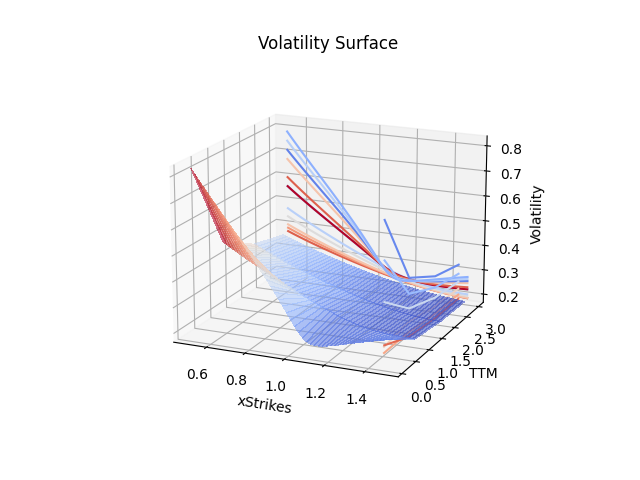

In [8]:
# 
refdate = dt.datetime(2017,1,1,0,0,0)
expiries = [dt.datetime(2017,2,1,0,0,0), dt.datetime(2018,1,1,0,0,0), dt.datetime(2019,1,1,0,0,0), dt.datetime(2020,1,1,0,0,0)]
def frange(x, y, count):
  jump = (y-x)/count
  while x <= y:
    yield x
    x += jump

x_strikes = list(frange(0.5, 1.5, 100))

x = x_strikes
y = ttm

term_structure = []
for i in x_strikes: 
    temp = []
    for j in expiries:
        temp.append(vol_surf.calcImpliedVol(refdate, j, i))
    term_structure.append(temp)

yv, xv = np.meshgrid(y, x)
xv = np.array(xv)  #strikes 1x no. strikes
yv = np.array(yv)  #ttm     1x no. ttms
z = np.array(term_structure)           #vols    no. strikes x no. ttms

# fig = mkt_plot.plt.figure()
fig = matplotlib.pyplot.figure()
ax4 = fig.add_subplot(111, projection='3d')
ax4.set_title('Volatility Surface')
ax4.set_xlabel('xStrikes')
ax4.set_ylabel('TTM')
ax4.set_zlabel('Volatility')
ax4.plot_surface(xv, yv, z, rstride=2, cstride=1, alpha=0.58, cmap=cm.coolwarm, linewidth=0, antialiased=False)
#ax4.plot_surface(xv, yv, z, rstride=8, cstride=1, alpha=0.3)

#ax4.contour(xv, yv, z, zdir='z', offset=ax4.get_zlim()[0], cmap=cm.coolwarm)
ax4.contour(xv, yv, z, zdir='x', offset=ax4.get_xlim()[1]-0.08, cmap=cm.coolwarm)
ax4.contour(xv, yv, z, zdir='y', offset=ax4.get_ylim()[1], cmap=cm.coolwarm)
ax4.contour(xv, yv, z, zdir='y', offset=ax4.get_ylim()[1], cmap=cm.coolwarm, levels = [0,0.2,0.3,0.5,0.7,0.8])
fig.show()

### Stickiness assumptions

In [9]:
forward_curve_shifted = mkt_data.EquityForwardCurve(1.02*spot, dc, bc, div_table)
vol_surf_shifted = pyvacon.finance.marketdata.VolatilitySurface.createVolatilitySurfaceShiftedFwd(vol_surf, forward_curve_shifted._get_pyvacon_obj())

In [13]:
pyvacon.finance.pricing.GlobalSettings.setVolatilitySurfaceFwdStickyness(pyvacon.finance.pricing.VolatilitySurfaceFwdStickyness.Type.StickyXStrike)
print(vol_surf_shifted.calcImpliedVol(refdate,refdate + dt.timedelta(days=180), 1.0))
pyvacon.finance.pricing.GlobalSettings.setVolatilitySurfaceFwdStickyness(pyvacon.finance.pricing.VolatilitySurfaceFwdStickyness.Type.StickyStrike)
print(vol_surf_shifted.calcImpliedVol(refdate,refdate + dt.timedelta(days=180), 1.0))

0.2819287824679105
0.27165643311101073


---